# Import Libraries and Data File

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')
import seaborn as sns
sns.set_style('darkgrid') 
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.arima_model import ARIMA, AutoReg
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
import itertools

In [3]:
df = pd.read_csv('zillow_data.csv')
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [4]:
df.dtypes

RegionID       int64
RegionName     int64
City          object
State         object
Metro         object
               ...  
2017-12        int64
2018-01        int64
2018-02        int64
2018-03        int64
2018-04        int64
Length: 272, dtype: object

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14723 entries, 0 to 14722
Columns: 272 entries, RegionID to 2018-04
dtypes: float64(219), int64(49), object(4)
memory usage: 30.6+ MB


In [6]:
# Drop unnecessary columns 
df.drop(['RegionID','SizeRank'], axis=1, inplace=True)

In [7]:
# Total number of zipcodes in Harris County, TX
df2 = df[(df['CountyName'] == 'Harris') & (df['State'] == 'TX')]
df2['RegionName'].nunique()

121

# Data Preprocessing

### Reshape from Wide to Long Format

In [8]:
# Function to reshape dataframe into a pandas datetime from wide to long format
def melt_data(df):
    melted = pd.melt(df, id_vars=['RegionName', 'City', 'State', 'Metro', 'CountyName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted.groupby('time').aggregate({'value':'mean'})

In [9]:
df_melt = melt_data(df)
df_melt.head()

,value
time,
1996-04-01,118299.123063
1996-05-01,118419.044139
1996-06-01,118537.423268
1996-07-01,118653.069278
1996-08-01,118780.254312


### Check for Trend, Seasonality and Noise

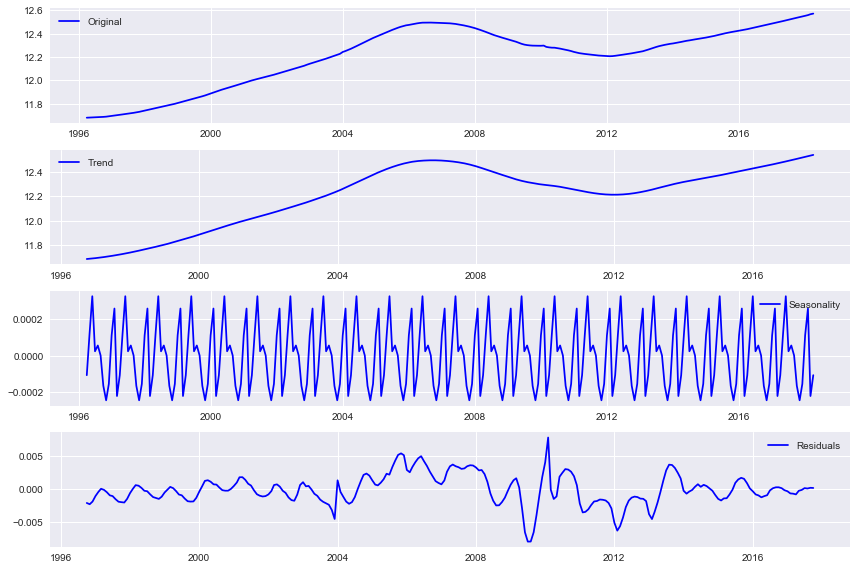

In [10]:
decomposition = seasonal_decompose(np.log(df_melt))

# Gather the trend, seasonality and noise of decomposed object
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot gathered statistics
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(np.log(df_melt), label='Original', color="blue")
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color="blue")
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label='Seasonality', color="blue")
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color="blue")
plt.legend(loc='best')
plt.tight_layout();

# Drop missing values from residuals
dfmelt_log_decomp = residual
dfmelt_log_decomp.dropna(inplace=True)

##### Comment:
There is a upward trend in the data, along with very little seasonality (according to the y-axis).

### Check for Stationarity

Most time series models require the data to be stationary. A time series is said to be stationary if its statistical properties such as mean, variance & covariance remain constant over time. We check for stationarity by using a visual analysis and performing a statistical test

In [11]:
# Function to check for the stationarity of a time series
# with Rolling Statistics and Dickey-Fuller Test
def stationarity_check(TS):    
    # Calculate rolling statistics
    roll_mean = TS.rolling(window=8, center = False).mean()
    roll_std = TS.rolling(window=8, center = False).std()
    
    # Perform the Dickey-Fuller Test
    dftest = adfuller(TS['value']) 
    
    # Plot rolling statistics
    fig = plt.figure(figsize=(12,6))
    plt.plot(TS, color='blue',label='Original')
    plt.plot(roll_mean, color='red', label='Rolling Mean')
    plt.plot(roll_std, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    # Print Dickey-Fuller test results
    print ('Results of Dickey-Fuller Test: \n')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic',
                                             'p-value',
                                             '#Lags Used',
                                             'Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    return None

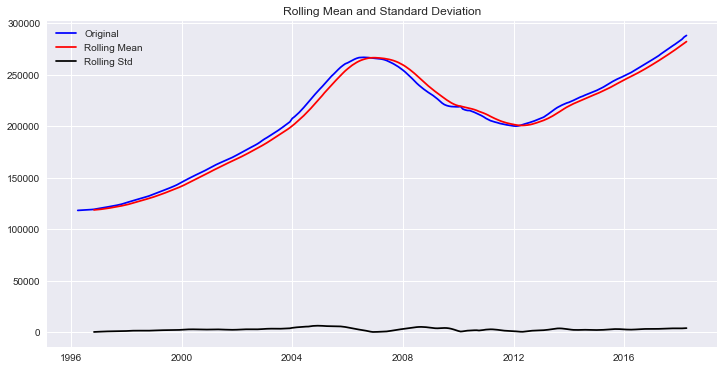

Results of Dickey-Fuller Test: 

Test Statistic                  -1.885145
p-value                          0.339082
#Lags Used                       2.000000
Number of Observations Used    262.000000
Critical Value (1%)             -3.455558
Critical Value (5%)             -2.872636
Critical Value (10%)            -2.572683
dtype: float64


In [12]:
stationarity_check(df_melt)

##### Comment:
The p-value is higher than the 0.05 significance value. Therefore, the null hypothesis fails to be rejected which means the time series dataset is not stationary. However, stationarity will be taken care of when tunning hyperparameters (p-lag order, d-degree of differencing, q-order of the moving average) in the later step

# Visualization

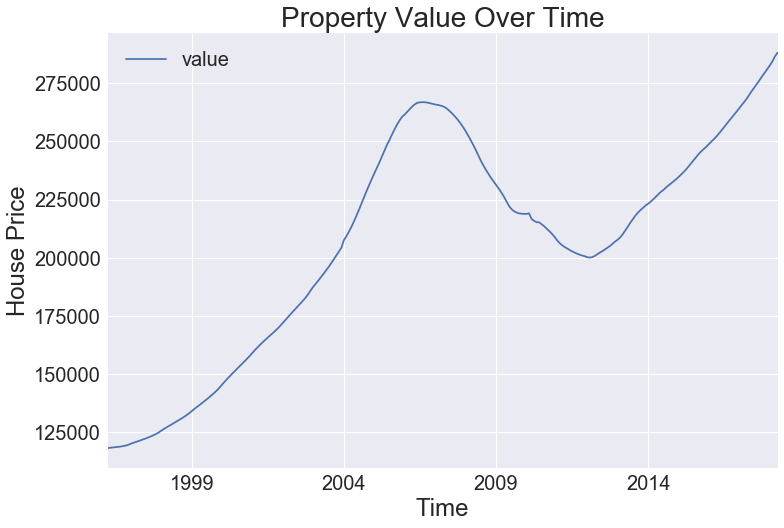

In [13]:
df_melt.plot(kind='line', figsize=(12,8))
plt.title('Property Value Over Time', fontsize=28)
plt.xlabel('Time', fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('House Price', fontsize=24)
plt.legend(fontsize=20);

##### Comment: 
There was a housing market crash in the years of 2008 and 2009, due to the recession. There is a very strong correlation between the property recent value and the distant past value as the houses lose and recover their values over time. 

# Time Series Analysis and ARIMA Modeling

Return On Investment, or called ROI is used to determined the Top 5 Zipcodes in Harris Country, TX for investment. 

ROI is the ratio between new profit over a period of time and the cost of investment. Therefore, the higher ROI, the more profit returns from the investment.

Stationarity is taken care of when running the function to find the best combination of (p,d,q) for the ARIMA model.

In [14]:
# Function to evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
    # Prepare training dataset
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # Make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # Calculate out of sample error
    error = mean_squared_error(test, predictions)
    return error

# Function to evaluate combinations of p, d and q for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))
    return best_cfg

In [10]:
# Function to loop through all zipcodes in Harris County, TX
# to give the best model based on smallest MSE value
roi_list = {}
for index, x in df[(df['CountyName'] == 'Harris') & (df['State'] == 'TX')].iterrows():
    print(x['RegionName'])
    series = melt_data(df.loc[[index]])
    # evaluate parameters
    p_values = [0, 1, 2]
    d_values = range(0, 2)
    q_values = range(0, 2)
    warnings.filterwarnings("ignore")
    
    order = evaluate_models(series.values, p_values, d_values, q_values)
    
    model= ARIMA(series, order=order)
    model_fit= model.fit()
    thirty_six_months = model_fit.forecast(steps=36)[0][-1]
    today = series.iloc[-1].value
    roi = (thirty_six_months - today)/today
    roi_list[x['RegionName']] = roi

77494
ARIMA(0, 0, 0) MSE=2073276628.837
ARIMA(0, 0, 1) MSE=525240997.364
ARIMA(0, 1, 0) MSE=2095195.972
ARIMA(0, 1, 1) MSE=898841.132
ARIMA(1, 0, 0) MSE=2686691.966
ARIMA(1, 1, 0) MSE=593860.641
ARIMA(2, 1, 0) MSE=622692.753
ARIMA(2, 1, 1) MSE=567189.460
Best ARIMA(2, 1, 1) MSE=567189.460
77084
ARIMA(0, 0, 0) MSE=591209013.652
ARIMA(0, 0, 1) MSE=150283310.692
ARIMA(0, 1, 0) MSE=547011.678
ARIMA(0, 1, 1) MSE=193633.615
ARIMA(1, 0, 0) MSE=702587.023
ARIMA(1, 1, 0) MSE=100188.030
ARIMA(1, 1, 1) MSE=78686.899
ARIMA(2, 0, 0) MSE=102388.828
ARIMA(2, 1, 0) MSE=87448.156
ARIMA(2, 1, 1) MSE=83470.616
Best ARIMA(1, 1, 1) MSE=78686.899
77449
ARIMA(0, 0, 0) MSE=719978089.089
ARIMA(0, 0, 1) MSE=183334922.902
ARIMA(0, 1, 0) MSE=719730.734
ARIMA(0, 1, 1) MSE=268916.547
ARIMA(1, 0, 0) MSE=945911.778
ARIMA(1, 1, 0) MSE=79857.768
ARIMA(1, 1, 1) MSE=69467.329
ARIMA(2, 0, 0) MSE=84724.266
ARIMA(2, 0, 1) MSE=71468.309
ARIMA(2, 1, 0) MSE=81604.938
ARIMA(2, 1, 1) MSE=83709.110
Best ARIMA(1, 1, 1) MSE=69467.3

ARIMA(2, 0, 0) MSE=136701.571
ARIMA(2, 1, 0) MSE=124468.570
ARIMA(2, 1, 1) MSE=96624.440
Best ARIMA(1, 1, 1) MSE=95804.025
77089
ARIMA(0, 0, 0) MSE=737566817.463
ARIMA(0, 0, 1) MSE=188656685.441
ARIMA(0, 1, 0) MSE=670248.289
ARIMA(0, 1, 1) MSE=222345.320
ARIMA(1, 0, 0) MSE=911789.118
ARIMA(1, 1, 0) MSE=98850.334
ARIMA(1, 1, 1) MSE=80135.639
ARIMA(2, 1, 0) MSE=93412.554
ARIMA(2, 1, 1) MSE=86760.554
Best ARIMA(1, 1, 1) MSE=80135.639
77339
ARIMA(0, 0, 0) MSE=1154444028.095
ARIMA(0, 0, 1) MSE=293442672.600
ARIMA(0, 1, 0) MSE=627575.170
ARIMA(0, 1, 1) MSE=221405.969
ARIMA(1, 0, 0) MSE=917405.080
ARIMA(1, 1, 0) MSE=112869.509
ARIMA(1, 1, 1) MSE=92289.310
ARIMA(2, 0, 0) MSE=115390.614
ARIMA(2, 1, 0) MSE=96900.770
ARIMA(2, 1, 1) MSE=95370.375
Best ARIMA(1, 1, 1) MSE=92289.310
77088
ARIMA(0, 0, 0) MSE=312735913.185
ARIMA(0, 0, 1) MSE=79989646.681
ARIMA(0, 1, 0) MSE=435253.208
ARIMA(0, 1, 1) MSE=161905.384
ARIMA(1, 0, 0) MSE=557474.887
ARIMA(1, 1, 0) MSE=79718.796
ARIMA(1, 1, 1) MSE=73668.068
AR

ARIMA(0, 0, 0) MSE=773061957.406
ARIMA(0, 0, 1) MSE=197459413.808
ARIMA(0, 1, 0) MSE=640964.698
ARIMA(0, 1, 1) MSE=230108.240
ARIMA(1, 0, 0) MSE=871879.236
ARIMA(1, 1, 0) MSE=101025.807
ARIMA(1, 1, 1) MSE=83101.631
ARIMA(2, 1, 0) MSE=87582.928
ARIMA(2, 1, 1) MSE=85506.789
Best ARIMA(1, 1, 1) MSE=83101.631
77073
ARIMA(0, 0, 0) MSE=348710922.044
ARIMA(0, 0, 1) MSE=88500228.458
ARIMA(0, 1, 0) MSE=633030.858
ARIMA(0, 1, 1) MSE=236092.191
ARIMA(1, 0, 0) MSE=745247.084
ARIMA(1, 1, 0) MSE=75690.756
ARIMA(1, 1, 1) MSE=72467.915
ARIMA(2, 0, 1) MSE=72779.192
ARIMA(2, 1, 0) MSE=76635.842
ARIMA(2, 1, 1) MSE=77823.696
Best ARIMA(1, 1, 1) MSE=72467.915
77079
ARIMA(0, 0, 0) MSE=6490146074.468
ARIMA(0, 0, 1) MSE=1619395979.362
ARIMA(0, 1, 0) MSE=5253387.862
ARIMA(0, 1, 1) MSE=1551898.545
ARIMA(1, 0, 0) MSE=4380855.130
ARIMA(1, 1, 0) MSE=829762.299
ARIMA(2, 1, 1) MSE=680613.724
Best ARIMA(2, 1, 1) MSE=680613.724
77025
ARIMA(0, 0, 0) MSE=5139325526.630
ARIMA(0, 0, 1) MSE=1282556688.767
ARIMA(0, 1, 0) MS

ARIMA(1, 0, 0) MSE=772088.480
ARIMA(1, 1, 0) MSE=117286.961
ARIMA(1, 1, 1) MSE=92659.638
ARIMA(2, 0, 1) MSE=94126.174
ARIMA(2, 1, 0) MSE=103991.314
ARIMA(2, 1, 1) MSE=93847.172
Best ARIMA(1, 1, 1) MSE=92659.638
77066
ARIMA(0, 0, 0) MSE=397724474.256
ARIMA(0, 0, 1) MSE=101571581.425
ARIMA(0, 1, 0) MSE=791724.214
ARIMA(0, 1, 1) MSE=285155.191
ARIMA(1, 0, 0) MSE=935361.729
ARIMA(1, 1, 0) MSE=184359.218
ARIMA(1, 1, 1) MSE=133836.612
ARIMA(2, 0, 0) MSE=186569.730
ARIMA(2, 1, 0) MSE=163826.771
ARIMA(2, 1, 1) MSE=136369.879
Best ARIMA(1, 1, 1) MSE=133836.612
77005
ARIMA(0, 0, 0) MSE=26600412366.257
ARIMA(0, 0, 1) MSE=6762995190.545
ARIMA(0, 1, 0) MSE=14570532.197
ARIMA(0, 1, 1) MSE=4489768.472
ARIMA(1, 0, 0) MSE=21208462.621
ARIMA(1, 1, 0) MSE=2544956.154
ARIMA(2, 0, 0) MSE=2748318.069
ARIMA(2, 1, 0) MSE=2778202.193
ARIMA(2, 1, 1) MSE=2190975.894
Best ARIMA(2, 1, 1) MSE=2190975.894
77530
ARIMA(0, 0, 0) MSE=483993532.243
ARIMA(0, 0, 1) MSE=124716390.861
ARIMA(0, 1, 0) MSE=638956.032
ARIMA(0, 1

ARIMA(1, 1, 1) MSE=3131266.771
ARIMA(2, 0, 0) MSE=4283517.067
ARIMA(2, 1, 0) MSE=3642023.357
ARIMA(2, 1, 1) MSE=3166792.663
Best ARIMA(1, 1, 1) MSE=3131266.771
77051
ARIMA(0, 0, 0) MSE=238347495.059
ARIMA(0, 0, 1) MSE=61243075.773
ARIMA(0, 1, 0) MSE=912579.413
ARIMA(0, 1, 1) MSE=427198.890
ARIMA(1, 0, 0) MSE=1008737.249
ARIMA(1, 1, 0) MSE=489474.712
ARIMA(1, 1, 1) MSE=387454.273
ARIMA(2, 0, 0) MSE=494123.821
ARIMA(2, 1, 0) MSE=447060.483
ARIMA(2, 1, 1) MSE=398821.101
Best ARIMA(1, 1, 1) MSE=387454.273
77031
ARIMA(0, 0, 0) MSE=633624912.586
ARIMA(0, 0, 1) MSE=161557825.251
ARIMA(0, 1, 0) MSE=1382242.779
ARIMA(0, 1, 1) MSE=442798.517
ARIMA(1, 0, 0) MSE=1574913.857
ARIMA(1, 1, 0) MSE=289926.466
ARIMA(1, 1, 1) MSE=208837.005
ARIMA(2, 1, 0) MSE=238942.621
ARIMA(2, 1, 1) MSE=213381.508
Best ARIMA(1, 1, 1) MSE=208837.005
77028
ARIMA(0, 0, 0) MSE=118536379.646
ARIMA(0, 0, 1) MSE=30599948.633
ARIMA(0, 1, 0) MSE=416302.408
ARIMA(0, 1, 1) MSE=269389.577
ARIMA(1, 0, 0) MSE=466527.173
ARIMA(1, 1, 0

In [11]:
# Sort the roi_list from highest to lowest ROI value
s = [(k, roi_list[k]) for k in sorted(roi_list, key=roi_list.get, reverse=True)]
for k, v in s:
    print(k, v)
# Choose Top 5 zipcodes in put in a new dataframe
top_5_zipcode = pd.DataFrame(s[:5])
top_5_zipcode.columns = ['ZipCode', 'ROI']
top_5_zipcode

77072 0.14603773131276876
77099 0.13314254101586045
77093 0.13054112172319524
77043 0.12793545476481188
77017 0.1277927263316477
77016 0.1190009617973485
77503 0.11556553473636144
77036 0.11314078962851168
77502 0.1106174203977435
77006 0.11004201669149047
77506 0.10842620905344388
77005 0.10414442225805044
77021 0.10410283800315984
77015 0.1040671266753494
77339 0.1036029034676159
77055 0.10022635684226332
77020 0.09839824550908115
77013 0.09770313037294222
77530 0.09715538022000571
77031 0.09643146279710338
77092 0.09402300183263822
77063 0.09366119328468003
77066 0.09254068398514287
77029 0.09229573438936384
77077 0.09155542308405241
77008 0.09048405714023636
77089 0.09032298339582279
77028 0.09022010115953112
77078 0.08902929066587643
77037 0.08642703571632226
77504 0.08531779858334732
77396 0.08497444914884553
77346 0.08452051380223694
77447 0.08428932842820462
77004 0.08324031780962729
77071 0.08274966054292655
77014 0.08201733279271145
77045 0.08163439828180834
77375 0.080829577

,ZipCode,ROI
0,77072,0.146038
1,77099,0.133143
2,77093,0.130541
3,77043,0.127935
4,77017,0.127793


# More details about Top 5 Zipcodes for Investment in Harris County

### 1) Zipcode: 77072

In [15]:
# Melt the time series data for the zipcode
harris_77072 = df[df['RegionName'] == 77072]
harris_77072 = melt_data(harris_77072)
harris_77072.head()

,value
time,
1996-04-01,65900.0
1996-05-01,65900.0
1996-06-01,65900.0
1996-07-01,66000.0
1996-08-01,66000.0


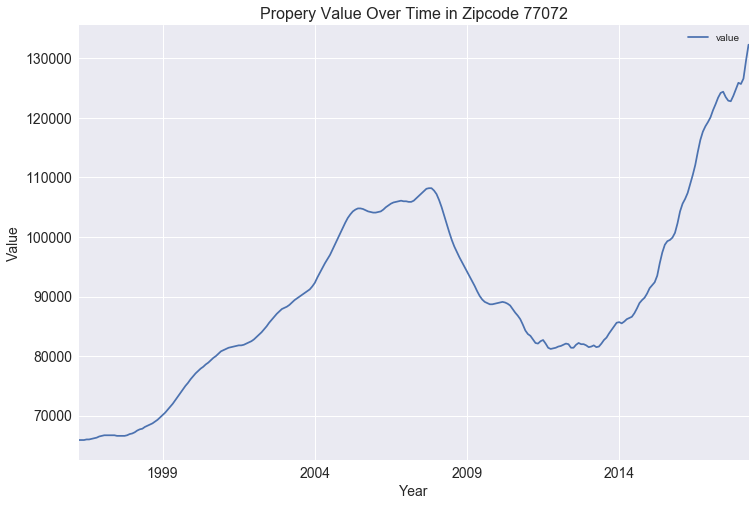

In [16]:
# Plot its property value over time
harris_77072.plot(figsize=(12,8))
plt.title('Propery Value Over Time in Zipcode 77072', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Value', fontsize=14);

                             ARIMA Model Results                              
Dep. Variable:                D.value   No. Observations:                  264
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1856.237
Method:                       css-mle   S.D. of innovations            272.750
Date:                Thu, 13 Aug 2020   AIC                           3720.474
Time:                        10:52:43   BIC                           3734.778
Sample:                    05-01-1996   HQIC                          3726.222
                         - 04-01-2018                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           281.8992    127.896      2.204      0.028      31.229     532.570
ar.L1.D.value     0.8104      0.040     20.243      0.000       0.732       0.889
ma.L1.D.value     0.4667      0.052     

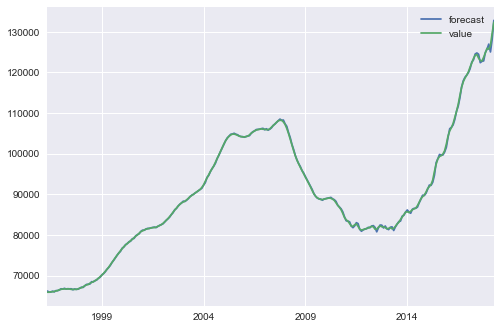

In [17]:
# Plug the optimal parameter values into a new ARIMA model for that zipcode
model_77072 = ARIMA(harris_77072, order = (1, 1, 1))
# Fit the model for the zipcode 
model_77072_fit = model_77072.fit(disp=0)
# Print the summary table and plot predict
print(model_77072_fit.summary())
model_77072_fit.plot_predict();

##### Comment: 
The significance of each feature weight P>|z| or the p-value is lower than 0.05. Therefore we can keep them all for the model.

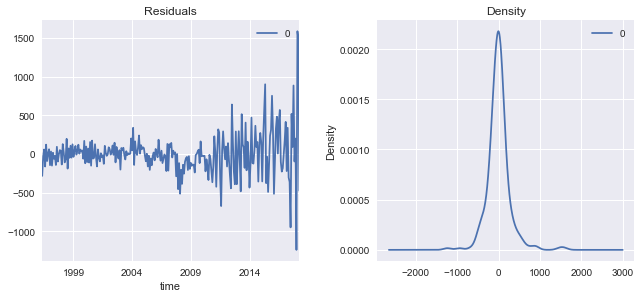

In [18]:
resid_77072 = pd.DataFrame(model_77072_fit.resid)
fig, ax = plt.subplots(1,2, figsize=(10,5))
fig.tight_layout(pad=5.0)
resid_77072.plot(title='Residuals', ax=ax[0])
resid_77072.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

##### Comment:
The residuals over time don’t display any obvious seasonality and appear to be white noise. The density plot shows normal distribution with mean zero. 

In [19]:
# Make a forecast for 3 years of investment
forecast_77072 = model_77072_fit.forecast(36)
actual_forecast_77072 = forecast_77072[0]
forecast_conf_int_77072 = forecast_77072[2]

In [20]:
# Make dataframe with forecast and 95% confidence interval 
df_forecast_77072 = pd.DataFrame({'time': pd.date_range(start = '2018-05-01', end = '2021-04-01', freq = 'MS')})
df_forecast_77072['forecast'] = actual_forecast_77072
df_forecast_77072['lower_bound'] = forecast_conf_int_77072[:, 0]
df_forecast_77072['upper_bound'] = forecast_conf_int_77072[:, 1]
df_forecast_77072.set_index('time', inplace = True)

In [21]:
# Combine raw data dataframe and forecast dataframe
df_77072 = pd.concat([harris_77072, df_forecast_77072])

Text(0.5, 1.0, 'Forecast for Zipcode 77072')

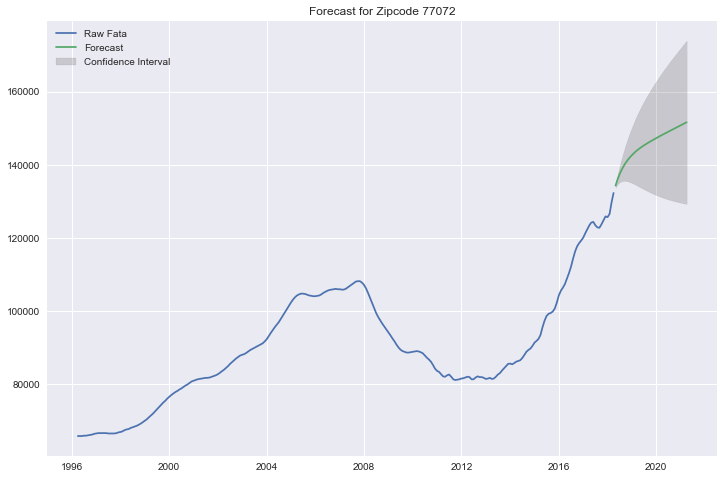

In [22]:
fig = plt.figure(figsize = (12, 8))

plt.plot(df_77072['value'], label = 'Raw Fata')
plt.plot(df_77072['forecast'], label = 'Forecast')
plt.fill_between(df_77072.index, df_77072['lower_bound'], df_77072['upper_bound'], 
                 color="k", alpha=.15, label = 'Confidence Interval')
plt.legend(loc = 'upper left')
plt.title('Forecast for Zipcode 77072')

In [23]:
# Predict property value after 3 years
forecast_77072_3yrs = df_77072.loc['2020-04-01', 'forecast']
forecast_77072_lower = df_77072.loc['2020-04-01', 'lower_bound']
forecast_77072_upper = df_77072.loc['2020-04-01', 'upper_bound']

In [24]:
last_price_77072 = harris_77072.loc['2017-05-01', 'value']

In [25]:
percent_return_77072 = (forecast_77072_3yrs - last_price_77072) / last_price_77072
print('Predicted percentage return on investment in 77072:', round(percent_return_77072*100, 2), '%')

Predicted percentage return on investment in 77072: 19.31 %


In [26]:
best_return_77072 = (forecast_77072_upper - last_price_77072) / last_price_77072
print('The maximum return percentage on investment in 77072:', round(best_return_77072*100, 2), '%')

The maximum return percentage on investment in 77072: 33.07 %


In [27]:
worst_return_77072 = (forecast_77072_lower - last_price_77072) / last_price_77072
print('The minimum return percentage on investment in 77072:', round(worst_return_77072*100, 2), '%')

The minimum return percentage on investment in 77072: 5.54 %


### 2) Zipcode: 77099

In [28]:
# Melt the time series data for the zipcode
harris_77099 = df[df['RegionName'] == 77099]
harris_77099 = melt_data(harris_77099)
harris_77099.head()

,value
time,
1996-04-01,72100.0
1996-05-01,72100.0
1996-06-01,72200.0
1996-07-01,72200.0
1996-08-01,72200.0


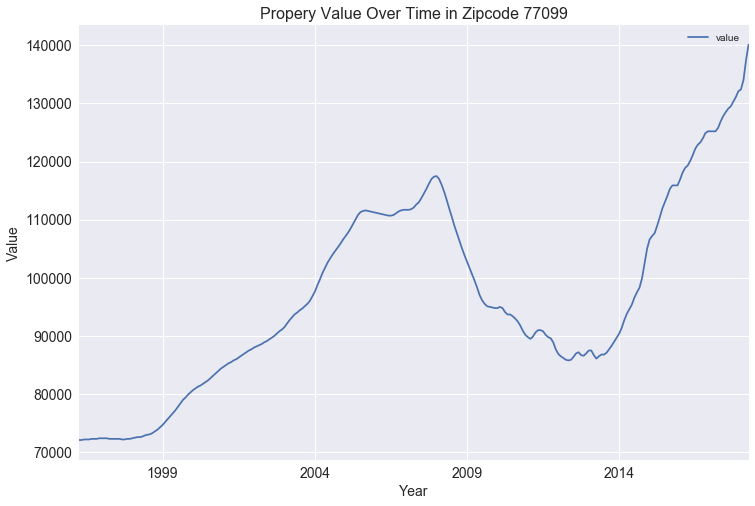

In [29]:
# Plot its property value over time
harris_77099.plot(figsize=(12,8))
plt.title('Propery Value Over Time in Zipcode 77099', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Value', fontsize=14);

                             ARIMA Model Results                              
Dep. Variable:                D.value   No. Observations:                  264
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1855.940
Method:                       css-mle   S.D. of innovations            272.342
Date:                Thu, 13 Aug 2020   AIC                           3719.880
Time:                        10:52:54   BIC                           3734.184
Sample:                    05-01-1996   HQIC                          3725.628
                         - 04-01-2018                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           283.4621    136.031      2.084      0.037      16.847     550.077
ar.L1.D.value     0.8136      0.039     20.901      0.000       0.737       0.890
ma.L1.D.value     0.5382      0.053     

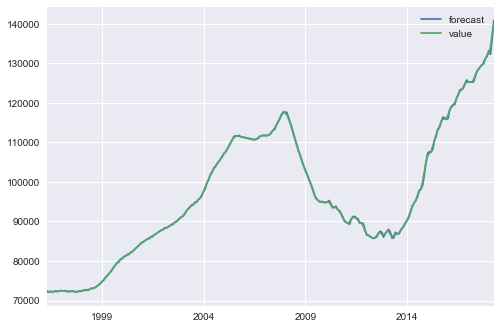

In [30]:
# Plug the optimal parameter values into a new ARIMA model for that zipcode
model_77099 = ARIMA(harris_77099, order = (1, 1, 1))
# Fit the model for the zipcode 
model_77099_fit = model_77099.fit(disp=0)
# Print the summary table and plot predict
print(model_77099_fit.summary())
model_77099_fit.plot_predict();

##### Comment: 
The significance of each feature weight P>|z| or the p-value is lower than 0.05. Therefore we can keep them all for the model.

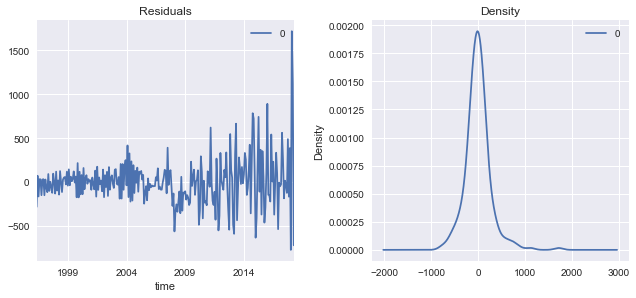

In [31]:
resid_77099 = pd.DataFrame(model_77099_fit.resid)
fig, ax = plt.subplots(1,2, figsize=(10,5))
fig.tight_layout(pad=5.0)
resid_77099.plot(title='Residuals', ax=ax[0])
resid_77099.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

##### Comment:
The residuals over time don’t display any obvious seasonality and appear to be white noise. The density plot shows normal distribution with mean zero.

In [32]:
# Make a forecast for 3 years of investment
forecast_77099 = model_77099_fit.forecast(36)
actual_forecast_77099 = forecast_77099[0]
forecast_conf_int_77099 = forecast_77099[2]

In [33]:
# Make dataframe with forecast and 95% confidence interval 
df_forecast_77099 = pd.DataFrame({'time': pd.date_range(start = '2018-05-01', end = '2021-04-01', freq = 'MS')})
df_forecast_77099['forecast'] = actual_forecast_77099
df_forecast_77099['lower_bound'] = forecast_conf_int_77099[:, 0]
df_forecast_77099['upper_bound'] = forecast_conf_int_77099[:, 1]
df_forecast_77099.set_index('time', inplace = True)

In [34]:
# Combine raw data dataframe and forecast dataframe
df_77099 = pd.concat([harris_77099, df_forecast_77099])

Text(0.5, 1.0, 'Forecast for Zipcode 77099')

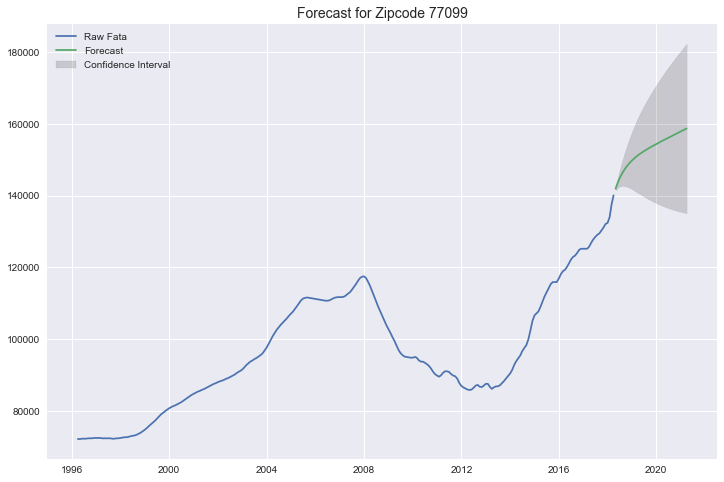

In [35]:
fig = plt.figure(figsize = (12, 8))

plt.plot(df_77099['value'], label = 'Raw Fata')
plt.plot(df_77099['forecast'], label = 'Forecast')
plt.fill_between(df_77099.index, df_77099['lower_bound'], df_77099['upper_bound'], 
                 color="k", alpha=.15, label = 'Confidence Interval')
plt.legend(loc = 'upper left')
plt.title('Forecast for Zipcode 77099', fontsize=14)

In [36]:
# Predict property value after 3 years
forecast_77099_3yrs = df_77099.loc['2020-04-01', 'forecast']
forecast_77099_lower = df_77099.loc['2020-04-01', 'lower_bound']
forecast_77099_upper = df_77099.loc['2020-04-01', 'upper_bound']

In [37]:
last_price_77099 = harris_77099.loc['2017-05-01', 'value']

In [38]:
percent_return_77099 = (forecast_77099_3yrs - last_price_77099) / last_price_77099
print('Predicted percentage return on investment in 77099:', round(percent_return_77099*100, 2), '%')

Predicted percentage return on investment in 77099: 22.38 %


In [39]:
best_return_77099 = (forecast_77099_upper - last_price_77099) / last_price_77099
print('The maximum return percentage on investment in 77099:', round(best_return_77099*100, 2), '%')

The maximum return percentage on investment in 77099: 36.66 %


In [40]:
worst_return_77099 = (forecast_77099_lower - last_price_77099) / last_price_77099
print('The minimum return percentage on investment in 77099:', round(worst_return_77099*100, 2), '%')

The minimum return percentage on investment in 77099: 8.11 %


### 3) Zipcode: 77093

In [41]:
# Melt the time series data for the zipcode
harris_77093 = df[df['RegionName'] == 77093]
harris_77093 = melt_data(harris_77093)
harris_77093.head()

,value
time,
1996-04-01,43200.0
1996-05-01,43200.0
1996-06-01,43300.0
1996-07-01,43300.0
1996-08-01,43300.0


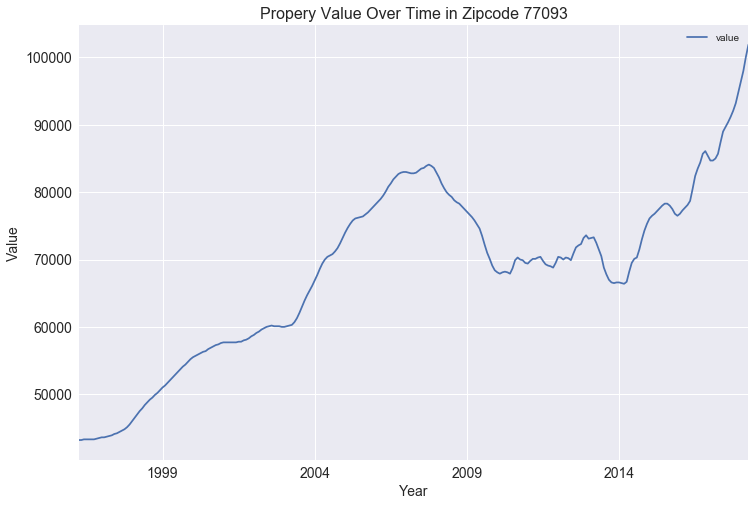

In [42]:
# Plot its property value over time
harris_77093.plot(figsize=(12,8))
plt.title('Propery Value Over Time in Zipcode 77093', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Value', fontsize=14);

                             ARIMA Model Results                              
Dep. Variable:                D.value   No. Observations:                  264
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1874.493
Method:                       css-mle   S.D. of innovations            292.489
Date:                Thu, 13 Aug 2020   AIC                           3756.985
Time:                        10:53:06   BIC                           3771.289
Sample:                    05-01-1996   HQIC                          3762.733
                         - 04-01-2018                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           232.4312     89.519      2.596      0.009      56.977     407.886
ar.L1.D.value     0.7000      0.050     13.929      0.000       0.601       0.798
ma.L1.D.value     0.5064      0.061     

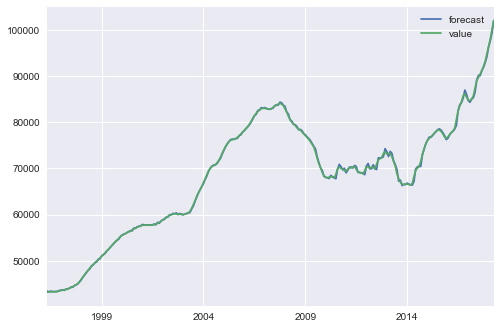

In [43]:
# Plug the optimal parameter values into a new ARIMA model for that zipcode
model_77093 = ARIMA(harris_77093, order = (1, 1, 1))
# Fit the model for the zipcode 
model_77093_fit = model_77093.fit(disp=0)
# Print the summary table and plot predict
print(model_77093_fit.summary())
model_77093_fit.plot_predict();

##### Comment: 
The significance of each feature weight P>|z| or the p-value is lower than 0.05. Therefore we can keep them all for the model.

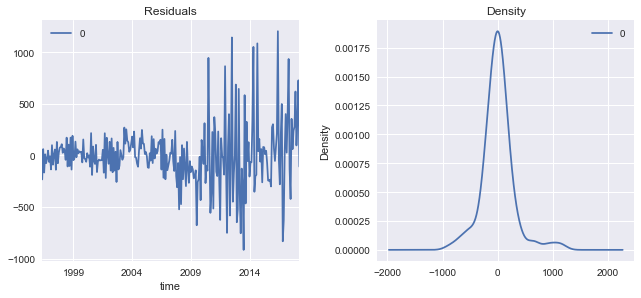

In [44]:
resid_77093 = pd.DataFrame(model_77093_fit.resid)
fig, ax = plt.subplots(1,2, figsize=(10,5))
fig.tight_layout(pad=5.0)
resid_77093.plot(title='Residuals', ax=ax[0])
resid_77093.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

##### Comment:
The residuals over time don’t display any obvious seasonality and appear to be white noise. The density plot shows normal distribution with mean zero.

In [45]:
# Make a forecast for 3 years of investment
forecast_77093 = model_77093_fit.forecast(36)
actual_forecast_77093 = forecast_77093[0]
forecast_conf_int_77093 = forecast_77093[2]

In [46]:
# Make dataframe with forecast and 95% confidence interval 
df_forecast_77093 = pd.DataFrame({'time': pd.date_range(start = '2018-05-01', end = '2021-04-01', freq = 'MS')})
df_forecast_77093['forecast'] = actual_forecast_77093
df_forecast_77093['lower_bound'] = forecast_conf_int_77093[:, 0]
df_forecast_77093['upper_bound'] = forecast_conf_int_77093[:, 1]
df_forecast_77093.set_index('time', inplace = True)

In [47]:
# Combine raw data dataframe and forecast dataframe
df_77093 = pd.concat([harris_77093, df_forecast_77093])

Text(0.5, 1.0, 'Forecast for Zipcode 77093')

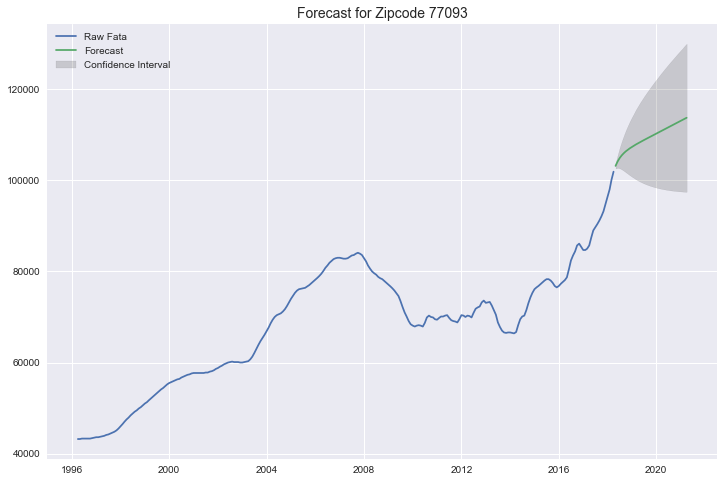

In [48]:
fig = plt.figure(figsize = (12, 8))

plt.plot(df_77093['value'], label = 'Raw Fata')
plt.plot(df_77093['forecast'], label = 'Forecast')
plt.fill_between(df_77093.index, df_77093['lower_bound'], df_77093['upper_bound'], 
                 color="k", alpha=.15, label = 'Confidence Interval')
plt.legend(loc = 'upper left')
plt.title('Forecast for Zipcode 77093', fontsize=14)

In [49]:
# Predict property value after 3 years
forecast_77093_3yrs = df_77093.loc['2020-04-01', 'forecast']
forecast_77093_lower = df_77093.loc['2020-04-01', 'lower_bound']
forecast_77093_upper = df_77093.loc['2020-04-01', 'upper_bound']

In [50]:
last_price_77093 = harris_77093.loc['2017-05-01', 'value']

In [51]:
percent_return_77093 = (forecast_77093_3yrs - last_price_77093) / last_price_77093
print('Predicted percentage return on investment in 77093:', round(percent_return_77093*100, 2), '%')

Predicted percentage return on investment in 77093: 26.95 %


In [52]:
best_return_77093 = (forecast_77093_upper - last_price_77093) / last_price_77093
print('The maximum return percentage on investment in 77093:', round(best_return_77093*100, 2), '%')

The maximum return percentage on investment in 77093: 41.65 %


In [53]:
worst_return_77093 = (forecast_77093_lower - last_price_77093) / last_price_77093
print('The minimum return percentage on investment in 77093:', round(worst_return_77093*100, 2), '%')

The minimum return percentage on investment in 77093: 12.25 %


### 4) Zipcode: 77043

In [54]:
# Melt the time series data for the zipcode
harris_77043 = df[df['RegionName'] == 77043]
harris_77043 = melt_data(harris_77043)
harris_77043.head()

,value
time,
1996-04-01,123400.0
1996-05-01,123300.0
1996-06-01,123300.0
1996-07-01,123500.0
1996-08-01,123800.0


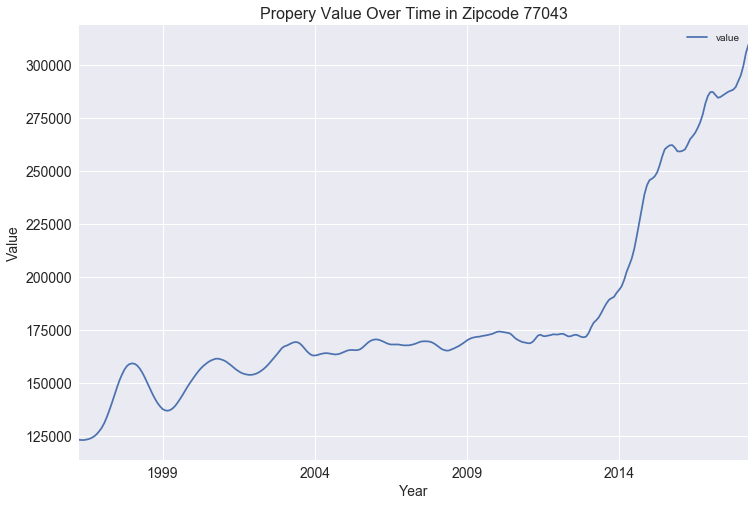

In [55]:
# Plot its property value over time
harris_77043.plot(figsize=(12,8))
plt.title('Propery Value Over Time in Zipcode 77043', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Value', fontsize=14);

                             ARIMA Model Results                              
Dep. Variable:                D.value   No. Observations:                  264
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2011.576
Method:                       css-mle   S.D. of innovations            490.549
Date:                Thu, 13 Aug 2020   AIC                           4031.152
Time:                        10:53:18   BIC                           4045.456
Sample:                    05-01-1996   HQIC                          4036.900
                         - 04-01-2018                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           733.9515    361.642      2.029      0.042      25.147    1442.756
ar.L1.D.value     0.8693      0.031     28.283      0.000       0.809       0.930
ma.L1.D.value     0.6067      0.040     

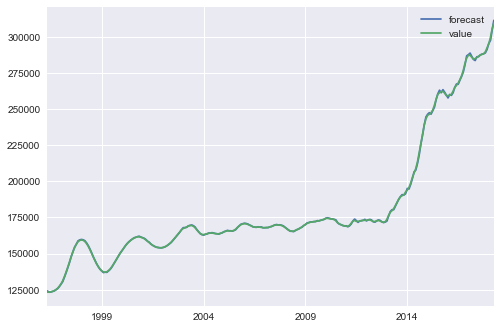

In [56]:
# Plug the optimal parameter values into a new ARIMA model for that zipcode
model_77043 = ARIMA(harris_77043, order = (1, 1, 1))
# Fit the model for the zipcode 
model_77043_fit = model_77043.fit(disp=0)
# Print the summary table and plot predict
print(model_77043_fit.summary())
model_77043_fit.plot_predict();

##### Comment: 
The significance of each feature weight P>|z| or the p-value is lower than 0.05. Therefore we can keep them all for the model.

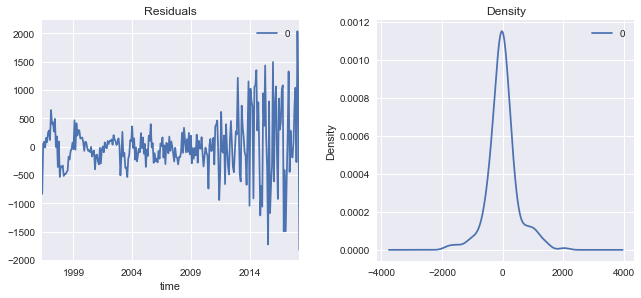

In [57]:
resid_77043 = pd.DataFrame(model_77043_fit.resid)
fig, ax = plt.subplots(1,2, figsize=(10,5))
fig.tight_layout(pad=5.0)
resid_77043.plot(title='Residuals', ax=ax[0])
resid_77043.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

##### Comment:
The residuals over time don’t display any obvious seasonality and appear to be white noise. The density plot shows normal distribution with mean zero.

In [58]:
# Make a forecast for 3 years of investment
forecast_77043 = model_77043_fit.forecast(36)
actual_forecast_77043 = forecast_77043[0]
forecast_conf_int_77043 = forecast_77043[2]

In [59]:
# Make dataframe with forecast and 95% confidence interval 
df_forecast_77043 = pd.DataFrame({'time': pd.date_range(start = '2018-05-01', end = '2021-04-01', freq = 'MS')})
df_forecast_77043['forecast'] = actual_forecast_77043
df_forecast_77043['lower_bound'] = forecast_conf_int_77043[:, 0]
df_forecast_77043['upper_bound'] = forecast_conf_int_77043[:, 1]
df_forecast_77043.set_index('time', inplace = True)

In [60]:
# Combine raw data dataframe and forecast dataframe
df_77043 = pd.concat([harris_77043, df_forecast_77043])

Text(0.5, 1.0, 'Forecast for Zipcode 77043')

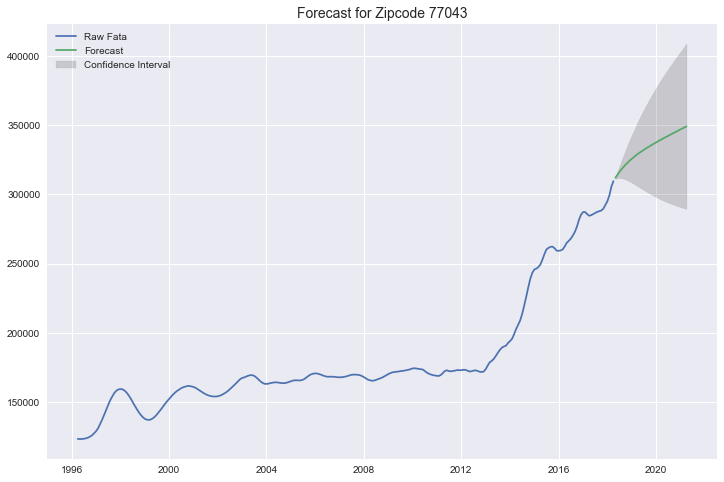

In [61]:
fig = plt.figure(figsize = (12, 8))

plt.plot(df_77043['value'], label = 'Raw Fata')
plt.plot(df_77043['forecast'], label = 'Forecast')
plt.fill_between(df_77043.index, df_77043['lower_bound'], df_77043['upper_bound'], 
                 color="k", alpha=.15, label = 'Confidence Interval')
plt.legend(loc = 'upper left')
plt.title('Forecast for Zipcode 77043', fontsize=14)

In [62]:
# Predict property value after 3 years
forecast_77043_3yrs = df_77043.loc['2020-04-01', 'forecast']
forecast_77043_lower = df_77043.loc['2020-04-01', 'lower_bound']
forecast_77043_upper = df_77043.loc['2020-04-01', 'upper_bound']

In [63]:
last_price_77043 = harris_77043.loc['2017-05-01', 'value']

In [64]:
percent_return_77043 = (forecast_77043_3yrs - last_price_77043) / last_price_77043
print('Predicted percentage return on investment in 77043:', round(percent_return_77043*100, 2), '%')

Predicted percentage return on investment in 77043: 19.31 %


In [65]:
best_return_77043 = (forecast_77043_upper - last_price_77043) / last_price_77043
print('The maximum return percentage on investment in 77043:', round(best_return_77043*100, 2), '%')


The maximum return percentage on investment in 77043: 34.76 %


In [66]:
worst_return_77043 = (forecast_77043_lower - last_price_77043) / last_price_77043
print('The minimum return percentage on investment in 77043:', round(worst_return_77043*100, 2), '%')

The minimum return percentage on investment in 77043: 3.86 %


### 5) Zipcode: 77017

In [67]:
# Melt the time series data for the zipcode
harris_77017 = df[df['RegionName'] == 77017]
harris_77017 = melt_data(harris_77017)
harris_77017.head()

,value
time,
1996-04-01,55700.0
1996-05-01,55700.0
1996-06-01,55800.0
1996-07-01,55800.0
1996-08-01,55900.0


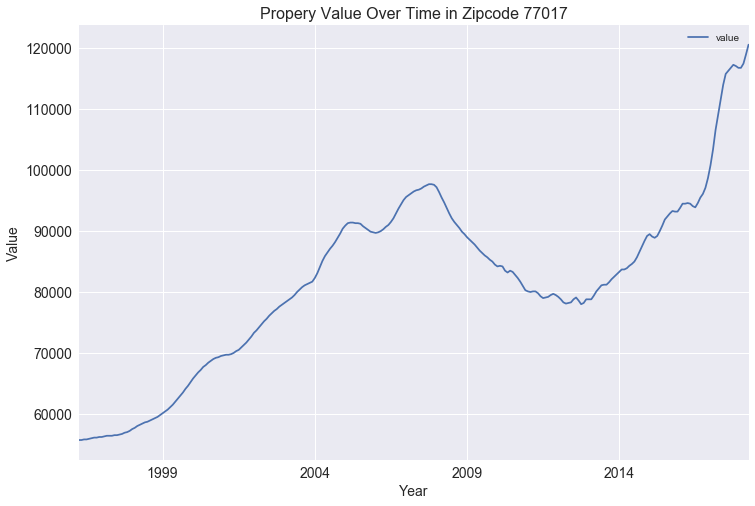

In [68]:
# Plot its property value over time
harris_77017.plot(figsize=(12,8))
plt.title('Propery Value Over Time in Zipcode 77017', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Value', fontsize=14);

                             ARIMA Model Results                              
Dep. Variable:                D.value   No. Observations:                  264
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1816.275
Method:                       css-mle   S.D. of innovations            234.414
Date:                Thu, 13 Aug 2020   AIC                           3640.549
Time:                        10:53:30   BIC                           3654.853
Sample:                    05-01-1996   HQIC                          3646.297
                         - 04-01-2018                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           262.2307    112.953      2.322      0.020      40.846     483.615
ar.L1.D.value     0.8143      0.039     20.897      0.000       0.738       0.891
ma.L1.D.value     0.4787      0.058     

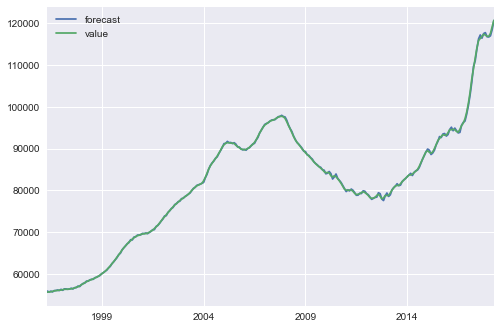

In [69]:
# Plug the optimal parameter values into a new ARIMA model for that zipcode
model_77017 = ARIMA(harris_77017, order = (1, 1, 1))
# Fit the model for the zipcode 
model_77017_fit = model_77017.fit(disp=0)
# Print the summary table and plot predict
print(model_77017_fit.summary())
model_77017_fit.plot_predict();

##### Comment: 
The significance of each feature weight P>|z| or the p-value is lower than 0.05. Therefore we can keep them all for the model.

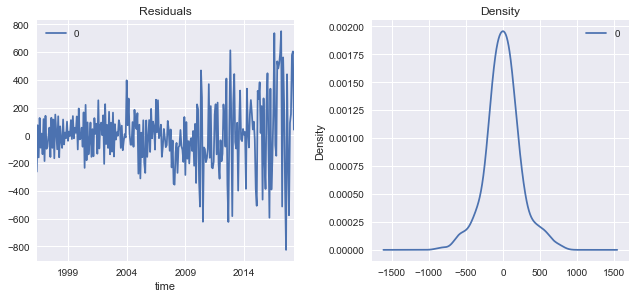

In [70]:
resid_77017 = pd.DataFrame(model_77017_fit.resid)
fig, ax = plt.subplots(1,2, figsize=(10,5))
fig.tight_layout(pad=5.0)
resid_77017.plot(title='Residuals', ax=ax[0])
resid_77017.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

##### Comment:
The residuals over time don’t display any obvious seasonality and appear to be white noise. The density plot shows normal distribution with mean zero.

In [71]:
# Make a forecast for 3 years of investment
forecast_77017 = model_77017_fit.forecast(36)
actual_forecast_77017 = forecast_77017[0]
forecast_conf_int_77017 = forecast_77017[2]

In [72]:
# Make dataframe with forecast and 95% confidence interval 
df_forecast_77017 = pd.DataFrame({'time': pd.date_range(start = '2018-05-01', end = '2021-04-01', freq = 'MS')})
df_forecast_77017['forecast'] = actual_forecast_77017
df_forecast_77017['lower_bound'] = forecast_conf_int_77017[:, 0]
df_forecast_77017['upper_bound'] = forecast_conf_int_77017[:, 1]
df_forecast_77017.set_index('time', inplace = True)

In [73]:
# Combine raw data dataframe and forecast dataframe
df_77017 = pd.concat([harris_77017, df_forecast_77017])

Text(0.5, 1.0, 'Forecast for Zipcode 77017')

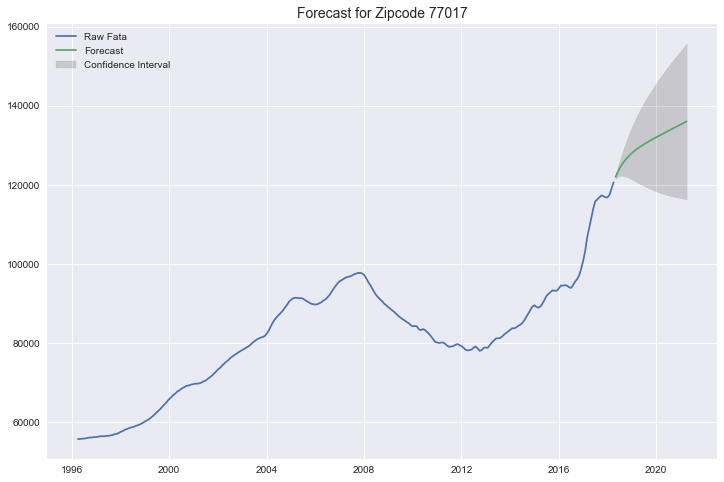

In [74]:
fig = plt.figure(figsize = (12, 8))

plt.plot(df_77017['value'], label = 'Raw Fata')
plt.plot(df_77017['forecast'], label = 'Forecast')
plt.fill_between(df_77017.index, df_77017['lower_bound'], df_77017['upper_bound'], 
                 color="k", alpha=.15, label = 'Confidence Interval')
plt.legend(loc = 'upper left')
plt.title('Forecast for Zipcode 77017', fontsize=14)

In [75]:
# Predict property value after 3 years
forecast_77017_3yrs = df_77017.loc['2020-04-01', 'forecast']
forecast_77017_lower = df_77017.loc['2020-04-01', 'lower_bound']
forecast_77017_upper = df_77017.loc['2020-04-01', 'upper_bound']

In [76]:
last_price_77017 = harris_77017.loc['2017-05-01', 'value']

In [77]:
percent_return_77017 = (forecast_77017_3yrs - last_price_77017) / last_price_77017
print('Predicted percentage return on investment in 77017:', round(percent_return_77017*100, 2), '%')

Predicted percentage return on investment in 77017: 19.12 %


In [78]:
best_return_77017 = (forecast_77043_upper - last_price_77017) / last_price_77017
print('The maximum return percentage on investment in 77017:', round(best_return_77017*100, 2), '%')

The maximum return percentage on investment in 77017: 244.34 %


In [79]:
worst_return_77017 = (forecast_77017_lower - last_price_77017) / last_price_77017
print('The minimum return percentage on investment in 77017:', round(worst_return_77017*100, 2), '%')

The minimum return percentage on investment in 77017: 5.63 %


# Visualize the Property Values of Top 5 Zipcodes in Harris County, TX

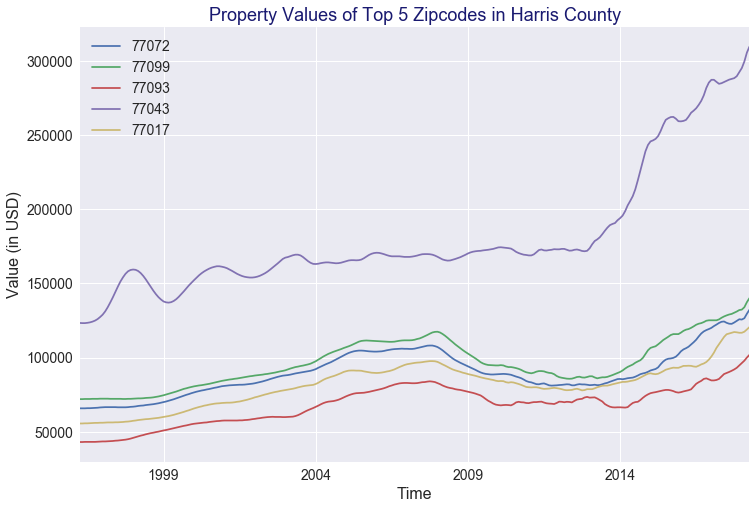

In [81]:
zipcodes = pd.concat([harris_77072, harris_77099, harris_77093, harris_77043, harris_77017], axis=1)
zipcodes.columns=['77072', '77099', '77093', '77043', '77017']
zipcodes.plot(figsize=(12,8))
plt.title('Property Values of Top 5 Zipcodes in Harris County', fontsize=18, color='midnightblue')
plt.xlabel('Time', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Value (in USD)', fontsize=16)
plt.legend(fontsize=14);